## Load Model

In [ ]:
from unsloth import FastModel
import torch

model, tokenizer = FastModel.from_pretrained(
    model_name = "/root/autodl-tmp/model/gemma3n_E2B", # gemma3n-e2b:5B gemma3n-e4b:8B
    max_seq_length = 1024, # Choose any for long context!
    load_in_4bit = False,  # 4 bit quantization to reduce memory
    attn_implementation = "eager", # necessary
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.2: Fast Gemma3N patching. Transformers: 4.53.2.
   \\   /|    NVIDIA RTX 5880 Ada Generation. Num GPUs = 1. Max memory: 47.383 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Inference

**Inputs and Outputs**

**Inputs**  
- Text string (question, prompt, document to summarize)  
- Images, normalized to 256×256, 512×512, or 768×768 and encoded to 256 tokens each  
- Audio data, single-channel, encoded to 6.25 tokens per second  
- Total input context: 32 K tokens  

**Outputs**  
- Generated text (answer, image analysis, document summary, etc.)  
- Total output length: up to 32 K tokens, minus the request input tokens

In [7]:
from transformers import TextStreamer
import gc

# Helper function for inference
def gemma3n_inference(model, messages, max_new_tokens = 128):
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt = True, # Must add for generation
        tokenize = True,
        return_dict = True,
        return_tensors = "pt",
    ).to("cuda")
    _ = model.generate(
        **inputs,
        max_new_tokens = max_new_tokens,
        temperature = 1.0, top_p = 0.95, top_k = 64,
        streamer = TextStreamer(tokenizer, skip_prompt = True),
    )
    # Cleanup to reduce VRAM usage
    del inputs
    torch.cuda.empty_cache()
    gc.collect()

### Image-Text-to-Text Task

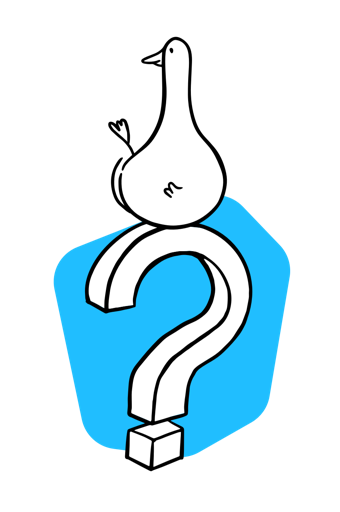

Image Size:(340, 512), Type:<class 'PIL.Image.Image'>


In [9]:
from PIL import Image


def resize_image_with_aspect_ratio(image: Image.Image, max_size: int) -> Image.Image:
    """
    Resizes an image to a maximum size while maintaining aspect ratio.

    Args:
        image (Image.Image): The PIL Image object.
        max_size (int): The maximum dimension (width or height).

    Returns:
        Image.Image: The resized PIL Image object.
    """
    width, height = image.size
    if width > max_size or height > max_size:
        if width > height:
            new_width = max_size
            new_height = int(height * (max_size / width))
        else:
            new_height = max_size
            new_width = int(width * (max_size / height))
        return image.resize((new_width, new_height))
    return image

image = Image.open("/root/autodl-tmp/kaggle408/resources/question_goose.png")
image = resize_image_with_aspect_ratio(image, 512)
display(image)
print(f"Image Size:{image.size}, Type:{type(image)}")

In [5]:
messages = [{
    "role" : "user",
    "content": [
        {"type": "image", "image": image},
        { "type": "text",  "text" : "Describe this image in detail." }
    ]
}]
# You might have to wait 1 minute for Unsloth's auto compiler
gemma3n_inference(model, messages, max_new_tokens = 256)

The image shows a stylized, cartoonish representation of a bird perched on a question mark. The bird is white with a rounded body and a small head. It has a curved beak pointing downwards and a small, stylized "m" on its body. The bird appears to be looking down at the question mark with a slightly tilted head.

The question mark itself is a classic, outlined shape with a solid white fill. It's positioned on a light blue, slightly curved shape that resembles a speech bubble or a stylized cloud. The question mark is sitting on a small, white rectangular base.

The overall style is simple and playful, with clean lines and a limited color palette of white and light blue. The image conveys a sense of curiosity, pondering, or seeking answers. The bird's posture and the question mark together strongly suggest a thought process or a moment of questioning.<end_of_turn>


### Text Generation Task

In [15]:
messages = [{
    "role" : "user",
    "content": [
        { "type": "text",  "text" : "Who are you?" }
    ]
}]

gemma3n_inference(model, messages, max_new_tokens = 128)

I'm Gemma, an open-weights AI assistant! I'm a large language model created by the Gemma team at Google DeepMind. I take text and image as inputs and output text only. I'm widely available to the public. 

Essentially, I'm designed to understand and generate human-like text. 
<end_of_turn>
